/tmp/ipykernel_17811/1040855228.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:1.0f}B'.format(x*1e-9) for x in current_values])


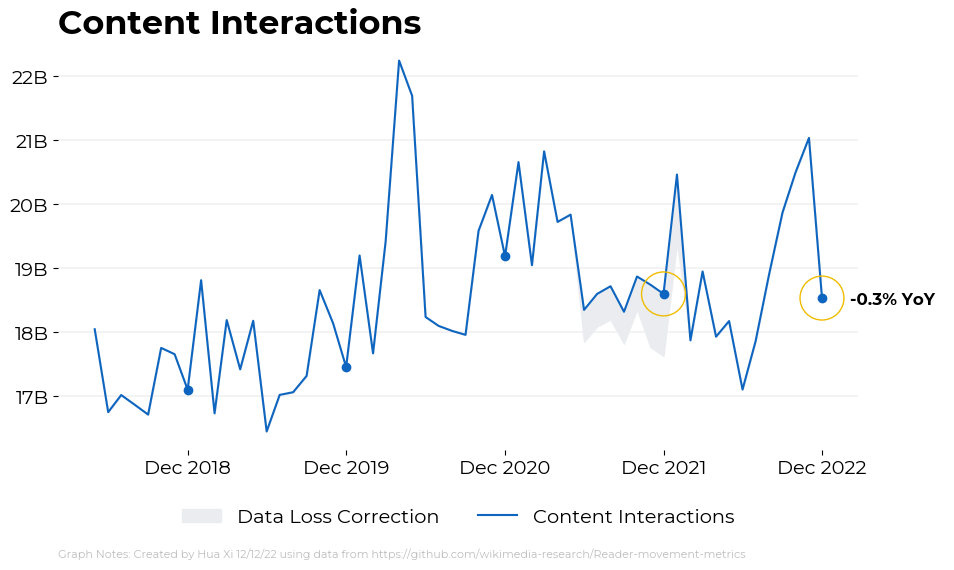

In [4]:
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager
import numpy as np
import os

#---PROMPT FOR INPUT---
outfile_name = "Content_Interactions_Chart.png"
yoy_note = " "

#---READ IN DATA---
#get current path
home_dir = os.getcwd()

df = pd.read_csv(home_dir + '/data/reader_metrics.tsv', sep='\t')
corrected_df = pd.read_csv(home_dir + '/data/corrected_metrics.csv')

#display top rows for preview
#df.iloc[0,:] 

#---CLEAN DATA--
#print out data types
#print(df.month.dtype)
#print(df.interactions.dtype)
#print(df.interactions_corrected.dtype)

#remove commas
corrected_df["interactions"] = corrected_df["interactions"].str.replace(",","")
corrected_df["interactions_corrected"] = corrected_df["interactions_corrected"].str.replace(",","")

#convert string to datetime
df['month'] = pd.to_datetime(df['month'])
corrected_df['month'] = pd.to_datetime(corrected_df['month'])

#truncate to preferred date range
df = df[df["month"].isin(pd.date_range("2018-05-01", "2022-12-01"))]
corrected_df = corrected_df[corrected_df["month"].isin(pd.date_range("2018-05-01", "2022-12-01"))]

#convert to int
corrected_df['interactions'] = corrected_df['interactions'].astype(str).astype(float)
corrected_df['interactions_corrected'] = corrected_df['interactions_corrected'].astype(str).astype(float)

#combine datasets — add corrected values to the reader metrics dataset
df['interactions_corrected'] = df['interactions']
correction_range = pd.date_range(start='2021-05-01', end='2022-02-01', freq='MS')
for m in correction_range:
	row_index = df[df['month'] == m].index 
	correct_row = corrected_df.loc[corrected_df['month'] ==  m]
	df.loc[row_index, 'interactions_corrected'] = correct_row['interactions_corrected']

#---BREAK DATA INTO SUBSETS--
#create subsets of data for easier plotting
data_loss_df = df[df["month"].isin(pd.date_range("2021-05-01", "2022-02-01"))]
#subset of just data for month of interest
monthly_df = df[df['month'].dt.month == 12]
#subset to highlight the last two months
yoy_highlight = pd.concat([df.iloc[-13,:],df.iloc[-1,:]],axis=1).T
#subset to highlight specific months (manually entered)
#highlighted_months = df[df['month'].isin(['2021-10-01','2022-10-01'])]

#---PREPARE TO PLOT ---
#adjust plot size
plt.rcParams["figure.figsize"] = [10, 6]

#create a dictionary for colors
wmf_colors = {'black75':'#404040','black50':'#7F7F7F','black25':'#BFBFBF','base80':'#eaecf0','base70':'#c8ccd1','blue':'#0E65C0','brightblue':'#049DFF','brightbluelight':'#C0E6FF','yellow':'#F0BC00','green':'#308557','brightgreen':'#71D1B3'}

#add Montserrat file by file (quick fix)
#font_montserrat = matplotlib.font_manager.FontProperties(fname="/srv/home/xihua/Key_Product_Metrics/fonts/Montserrat/static/Montserrat-Regular.ttf")
#font_montserrat_bold = matplotlib.font_manager.FontProperties(fname="/srv/home/xihua/Key_Product_Metrics/fonts/Montserrat/static/Montserrat-Bold.ttf")

font_dirs = [home_dir + "/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

#check added fonts
#result = custom_font_manager.get_font_names()
#print(result)

#add grid lines
#thin light black line
plt.grid(axis = 'y', color = wmf_colors['black25'], linewidth = 0.25)
#dashed light black line
#plt.grid(axis = 'y', color = wmf_colors['black25'], linestyle = '--', linewidth = 0.5)

#---PLOT---
#plot data loss area
plt.fill_between(df.month, df.interactions, df.interactions_corrected,
	label='Data Loss Correction',
	color=wmf_colors['base80'],
	edgecolor=wmf_colors['base80'],
	zorder=3)
#linestyle='dashed'

#plot data before and after data loss period
plt.plot(df.month, df.interactions_corrected,
	label="Content Interactions",
	color=wmf_colors['blue'],
	zorder=4)

#draw circle on octobers by plotting scatter
plt.scatter(monthly_df.month, monthly_df.interactions_corrected,
	label='_nolegend_',
	color=wmf_colors['blue'],
	zorder=5)

#draw circle on 2021 and 2022 to highlight for comparison
#scatter s variable sets size by "typographic points"
highlight_radius = 1000000
plt.scatter(yoy_highlight.month, yoy_highlight.interactions_corrected,
	label='_nolegend_',
	s=(highlight_radius**0.5),
	facecolors='none',
	edgecolors=wmf_colors['yellow'],
	zorder=8)
#I explored using plt.patch.Circle but due to the unequal axes, it caused more trouble than this even though typographic points is not the ideal metric to be using


#---FORMATTING---
#add title and axis labels
plt.title('Content Interactions',font='Montserrat',weight='bold',fontsize=24,loc='left')
#plt.xlabel("Month",font='Montserrat', fontsize=18, labelpad=10) #source serif pro
#plt.ylabel("Active Editors",font='Montserrat', fontsize=14)

#add october x-axis labels
date_labels = []
for dl in monthly_df['month']:
	date_labels.append(datetime.datetime.strftime(dl, '%b %Y'))

#adjust axis ticks
plt.yticks(fontsize=14)
#add major ticks
#plt.rcParams["xtick.major.size"] = 20
plt.xticks(ticks=monthly_df['month'],labels=date_labels,fontsize=14,minor=False)
#add minor ticks
#plt.rcParams["xtick.minor.size"] = 2
#plt.xticks(ticks=df['month'],minor=True)
#print(plt.rcParams["xtick.major.size"])

#format axis labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:1.0f}B'.format(x*1e-9) for x in current_values])
plt.xticks(fontname = 'Montserrat')
plt.yticks(fontname = 'Montserrat')

#add legend
#plt.legend(fontsize=18)
matplotlib.rcParams['legend.fontsize'] = 14
plt.legend(frameon=False,
	loc ="upper center",
	bbox_to_anchor=(0.5, -0.1, ),
	fancybox=False, 
	shadow=False,
	ncol=4, 
	prop={"family":"Montserrat"})

#expand bottom margin
plt.subplots_adjust(bottom=0.2, left=0.1)

#remove bounding box
for pos in ['right', 'top', 'bottom', 'left']:
	plt.gca().spines[pos].set_visible(False)

#---ADD ANNOTATIONS---
#YoY Change Annotation
#calculate YoY change
def annotate():
	yoy_change_percent = ((yoy_highlight['interactions_corrected'].iat[-1] - yoy_highlight['interactions_corrected'].iat[0]) /  yoy_highlight['interactions_corrected'].iat[0]) * 100
	#make YoY annotation (add text her if relevant)
	if yoy_change_percent > 0:
		yoy_annotation = f"+{yoy_change_percent:.1f}% YoY" + " " + yoy_note
	else:
		yoy_annotation = f"{yoy_change_percent:.1f}% YoY" + " " + yoy_note
	#annotate
	plt.annotate(yoy_annotation,
		xy = (yoy_highlight['month'].iat[-1],yoy_highlight['interactions_corrected'].iat[-1]),
		xytext = (20,-5),
		xycoords = 'data',
		textcoords = 'offset points',
		color='black',
		family='Montserrat',
		fontsize=12,
		weight='bold',
		wrap=True,
		bbox=dict(pad=10, facecolor="white", edgecolor="none"))
annotate()

#data notes
plt.figtext(0.1, 0.02, "Graph Notes: Created by Hua Xi 12/12/22 using data from https://github.com/wikimedia-research/Reader-movement-metrics", fontsize=8, family='Montserrat', color= wmf_colors['black25'])

#---SHOW GRAPH---
#save as image
save_file_name = home_dir + "/charts/" + outfile_name
plt.savefig(save_file_name, dpi=300)
#show in window
plt.show()